In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.__version__

'2.1.0'

In [77]:
import glob
# import imageio  # To generate GIFs
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tqdm import tqdm
from tensorflow.keras import layers
import time
from dataset_loader import load_and_split_dataset

from IPython import display

In [81]:
# TODO: Import own dataset of kidney stone
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

ks_dir_path_SEC = '../../dataset_calculs_classed/SEC'

train_images, train_labels, test_images, test_labels, excluded_classes = load_and_split_dataset(ks_dir_path_SEC, image_size=(28, 28))

In [82]:
print(train_images.shape)
print(train_images.dtype)
print(test_images.shape)
print('Excluded classes:',excluded_classes)

(60, 28, 28, 3)
uint8
(26, 28, 28, 3)
Excluded classes: ['SEC', 'Ic_SEC', 'IIa_SEC', 'IVa2_SEC']


## Preprocessing

We need to make sure images in the dataset have shape of (*size*, *size*, channels).  
We also normalize pixels value to ease learning.

In [4]:
train_images.shape

(60000, 28, 28)

In [83]:
train_images = train_images.astype('float32')
train_images = train_images / 255 # Normalize the images to [0, 1]

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 32

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

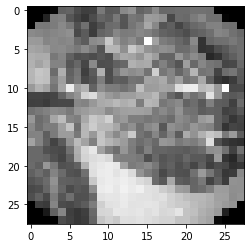

In [84]:
plt.imshow(train_images[0,:,:,0], cmap='gray')

## Generator

In [88]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
#     model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#     assert model.output_shape == (None, 7, 7, 512)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 3)

    return model

### Test Generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 28, 28, 3)


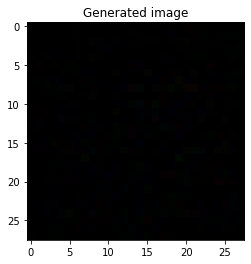

In [89]:
generator = make_generator_model()

noise = tf.random.uniform([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

# plt.figure()
# plt.title("Random noise")
# plt.imshow(np.random.rand(28, 28), cmap='gray')

plt.figure()
plt.title("Generated image")
plt.imshow(generated_image[0, :, :, :])#, cmap='gray')

## Discriminator

In [92]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [93]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00148413]], shape=(1, 1), dtype=float32)


# Define loss and optimizer

In [94]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [95]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [96]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [97]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [98]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training loop

In [106]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.uniform([num_examples_to_generate, noise_dim])

In [107]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [101]:
def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    checkpoint.save(file_prefix = checkpoint_prefix)

In [103]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train

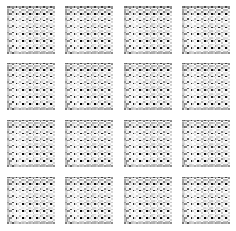

In [108]:
train(train_dataset, EPOCHS)

# Use classes

In [ ]:
class GAN:
    def __init__(self):
        self.generator = make_generator_model()
        self.discriminator = make_discriminator_model()
        
    def load(self, model_path):
        